## imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *

from mlcrate import *
import time
from gplearn.genetic import SymbolicTransformer
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import gc
from scipy.cluster import hierarchy as hc
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
#will ignore all warning from sklearn, seaborn etc..

pd.option_context("display.max_rows", 1000);
pd.option_context("display.max_columns", 1000);

In [2]:
PATH = os.getcwd();
PATH

'D:\\Github\\fastai\\courses\\ml1'

In [11]:
df_raw  = pd.read_csv(f'{PATH}\\AV_Stud\\lgb_train_v1.csv', low_memory= False)
df_test = pd.read_csv(f'{PATH}\\AV_Stud\\lgb_test_v1.csv', low_memory=False)

In [60]:
df_raw.columns[:3]

Index(['Unnamed: 0', 'program_id', 'program_type'], dtype='object')

In [90]:
df_raw.drop('Unnamed: 0', axis=1, inplace=True)
df_test.drop('Unnamed: 0', axis=1, inplace=True)

In [64]:
df_raw.head(2)

,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,...,impact_encoded_is_handicapped,impact_encoded_trainee_engagement_rating,impact_encoded_program_type__program_duration,impact_encoded_test_id__program_duration,impact_encoded_test_id__test_type,impact_encoded_test_type__difficulty_level,impact_encoded_education__gender,impact_encoded_education__city_tier,impact_encoded_gender__city_tier,is_pass
0,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,...,0.701995,0.592726,0.785453,0.751688,0.751967,0.656276,0.653450,0.646735,0.698832,0
1,T_1,T,131,44,offline,easy,16523,F,High School Diploma,4,...,0.701995,0.737547,0.513423,0.467994,0.467950,0.619956,0.708825,0.653126,0.602991,1


In [5]:
cols_dropped = ['id']
target = df_raw.is_pass
df_raw.drop('is_pass', inplace=True, axis =1)

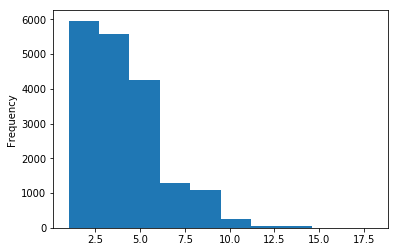

In [6]:
df_raw['trainee_id'].value_counts().sort_values(ascending=False).plot(kind='hist')

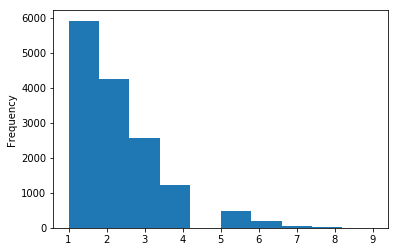

In [7]:
df_test['trainee_id'].value_counts().sort_values(ascending=False).plot(kind='hist')

In [8]:
from collections import Counter

train_trainee_id = Counter(df_raw['trainee_id'])
test_trainee_id = Counter(df_test['trainee_id'])

######################### New Cols Added ##########################

df_raw['trainee_count'] = df_raw['trainee_id'].map(train_trainee_id).astype(np.int32)
df_test['trainee_count'] = df_test['trainee_id'].map(train_trainee_id).astype(np.int32)

########################### Creating Validation Dataset #########################

'''
rows_to_dropped = df_raw.loc[df_raw['trainee_count'] <=3].index
valid_data = df_raw.loc[df_raw['trainee_count'] <=3]

df_raw.drop(rows_to_dropped, inplace=True)
df_raw.shape

########################## Done For Temp ########################################
''';

In [9]:
##################### Dropping ID #######################
df_raw.drop('id', axis =1, inplace=True)
df_test.drop('id', axis =1, inplace=True)
#########################################################

## encoding means

In [10]:
# This way we have randomness and are able to reproduce the behaviour within this cell.
np.random.seed(13)
from sklearn.model_selection import KFold

def impact_coding(data, feature, target='y'):
    '''
    In this implementation we get the values and the dictionary as two different steps.
    This is just because initially we were ignoring the dictionary as a result variable.
    
    In this implementation the KFolds use shuffling. If you want reproducibility the cv 
    could be moved to a parameter.
    '''
    n_folds = 7
    n_inner_folds = 5
    impact_coded = pd.Series()
    
    oof_default_mean = data[target].mean() # Gobal mean to use by default (you could further tune this)
    kf = KFold(n_splits=n_folds, shuffle=True)
    oof_mean_cv = pd.DataFrame()
    split = 0
    for infold, oof in kf.split(data[feature]):
            impact_coded_cv = pd.Series()
            kf_inner = KFold(n_splits=n_inner_folds, shuffle=True)
            inner_split = 0
            inner_oof_mean_cv = pd.DataFrame()
            oof_default_inner_mean = data.iloc[infold][target].mean()
            for infold_inner, oof_inner in kf_inner.split(data.iloc[infold]):
                # The mean to apply to the inner oof split (a 1/n_folds % based on the rest)
                oof_mean = data.iloc[infold_inner].groupby(by=feature)[target].mean()
                impact_coded_cv = impact_coded_cv.append(data.iloc[infold].apply(
                            lambda x: oof_mean[x[feature]]
                                      if x[feature] in oof_mean.index
                                      else oof_default_inner_mean
                            , axis=1))

                # Also populate mapping (this has all group -> mean for all inner CV folds)
                inner_oof_mean_cv = inner_oof_mean_cv.join(pd.DataFrame(oof_mean), rsuffix=inner_split, how='outer')
                inner_oof_mean_cv.fillna(value=oof_default_inner_mean, inplace=True)
                inner_split += 1

            # Also populate mapping
            oof_mean_cv = oof_mean_cv.join(pd.DataFrame(inner_oof_mean_cv), rsuffix=split, how='outer')
            oof_mean_cv.fillna(value=oof_default_mean, inplace=True)
            split += 1
            
            impact_coded = impact_coded.append(data.iloc[oof].apply(
                            lambda x: inner_oof_mean_cv.loc[x[feature]].mean()
                                      if x[feature] in inner_oof_mean_cv.index
                                      else oof_default_mean
                            , axis=1))

    return impact_coded, oof_mean_cv.mean(axis=1), oof_default_mean

In [13]:
df_raw['program_type__program_duration'] = df_raw.program_type.str.cat(df_raw.program_duration.astype(str),sep='_')
df_raw['test_id__program_duration'] = df_raw.test_id.astype(str).str.cat(df_raw.program_duration.astype(str),sep='_')
df_raw['test_id__test_type'] = df_raw.test_id.astype(str).str.cat(df_raw.test_type.astype(str),sep='_')
df_raw['test_type__difficulty_level'] = df_raw.test_type.str.cat(df_raw.difficulty_level.astype(str),sep='_')
df_raw['education__gender'] = df_raw.education.str.cat(df_raw.gender.astype(str),sep='_')
df_raw['education__city_tier'] = df_raw.education.str.cat(df_raw.city_tier.astype(str),sep='_')
df_raw['gender__city_tier'] = df_raw.gender.str.cat(df_raw.city_tier.astype(str),sep='_')
df_raw['trainee_engagement_rating']  = df_raw['trainee_engagement_rating'].astype(object)
###########################kind of binning age at trivial level #####################################

df_raw['is_age_39'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('age<=39.').index
df_raw.iloc[my_query, -1] = 1
df_raw['is_age_39_45'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('age>=39. & age<=45.').index
df_raw.iloc[my_query, -1] = 1
df_raw['is_age_45'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('age>=45.').index
df_raw.iloc[my_query, -1] = 1

#######################################################################################################
###################young age (13–30), middle age (31–50) and senior age (51–70)########################
#######################################################################################################

'''df_raw['age_group'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('age>=13. & age<=30.').index
df_raw.iloc[my_query, -1] = 'young'
my_query = df_raw.query('age>=31. & age<=50.').index
df_raw.iloc[my_query, -1] = 'middle_aged'
my_query = df_raw.query('age>=51. & age<=70.').index
df_raw.iloc[my_query, -1] = 'senior_aged'''
###################################################################################################################
###################################################################################################################
###################################################################################################################

df_test['program_type__program_duration'] = df_test.program_type.str.cat(df_test.program_duration.astype(str),sep='_')
df_test['test_id__program_duration'] = df_test.test_id.astype(str).str.cat(df_test.program_duration.astype(str),sep='_')
df_test['test_id__test_type'] = df_test.test_id.astype(str).str.cat(df_test.test_type.astype(str),sep='_')
df_test['test_type__difficulty_level'] = df_test.test_type.str.cat(df_test.difficulty_level.astype(str),sep='_')
df_test['education__gender'] = df_test.education.str.cat(df_test.gender.astype(str),sep='_')
df_test['education__city_tier'] = df_test.education.str.cat(df_test.city_tier.astype(str),sep='_')
df_test['gender__city_tier'] = df_test.gender.str.cat(df_test.city_tier.astype(str),sep='_')
df_test['trainee_engagement_rating']  = df_test['trainee_engagement_rating'].astype(object)
###########################kind of binning age at trivial level #####################################

df_test['is_age_39'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age<=39.').index
df_test.iloc[my_query, -1] = 1
df_test['is_age_39_45'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age>=39. & age<=45.').index
df_test.iloc[my_query, -1] = 1
df_test['is_age_45'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age>=45.').index
df_test.iloc[my_query, -1] = 1

#######################################################################################################
###################young age (13–30), middle age (31–50) and senior age (51–70)########################
#######################################################################################################
'''
df_test['age_group'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age>=13. & age<=30.').index
df_test.iloc[my_query, -1] = 'young'
my_query = df_test.query('age>=31. & age<=50.').index
df_test.iloc[my_query, -1] = 'middle_aged'
my_query = df_test.query('age>=51. & age<=70.').index
df_test.iloc[my_query, -1] = 'senior_aged''';
###############################################################################

In [14]:
features = df_raw.columns
numeric_features = []
categorical_features = []

for dtype, feature in zip(df_raw.dtypes, df_raw.columns):
    if dtype == object:
        #print(column)
        #print(train_data[column].describe())
        categorical_features.append(feature)
    else:
        numeric_features.append(feature)
categorical_features

['program_id',
 'program_type',
 'test_type',
 'difficulty_level',
 'gender',
 'education',
 'is_handicapped',
 'trainee_engagement_rating',
 'program_type__program_duration',
 'test_id__program_duration',
 'test_id__test_type',
 'test_type__difficulty_level',
 'education__gender',
 'education__city_tier',
 'gender__city_tier']

In [15]:
df_raw['is_pass'] = target
###############################remeber to drop the target column again after the next block

In [16]:
%%time
# Apply the encoding to training and test data, and preserve the mapping
impact_coding_map = {}
for f in categorical_features:
    print("Impact coding for {}".format(f))
    df_raw["impact_encoded_{}".format(f)], impact_coding_mapping, default_coding = impact_coding(df_raw, f,'is_pass')
    impact_coding_map[f] = (impact_coding_mapping, default_coding)
    mapping, default_mean = impact_coding_map[f]
    df_test["impact_encoded_{}".format(f)] = df_test.apply(lambda x: mapping[x[f]]
                                                                         if x[f] in mapping
                                                                         else default_mean
                                                               , axis=1)

df_raw.drop('is_pass', inplace=True, axis =1);

Impact coding for program_id
Impact coding for program_type
Impact coding for test_type
Impact coding for difficulty_level
Impact coding for gender
Impact coding for education
Impact coding for is_handicapped
Impact coding for trainee_engagement_rating
Impact coding for program_type__program_duration
Impact coding for test_id__program_duration
Impact coding for test_id__test_type
Impact coding for test_type__difficulty_level
Impact coding for education__gender
Impact coding for education__city_tier
Impact coding for gender__city_tier
Wall time: 19min 25s


In [17]:
##################### sanity check  should be empty #####################
set(df_raw.columns) - set(df_test.columns)

set()

In [18]:
df_raw['is_pass'] = target
df_raw.to_csv(f'{PATH}\\AV_Stud\\lgb_train_v1.csv')
df_test.to_csv(f'{PATH}\\AV_Stud\\lgb_test_v1.csv')
df_raw.drop('is_pass', inplace=True, axis =1);

## modelling

In [20]:
X_train, X_test, y = df_raw.copy(), df_test.copy(), target

In [21]:
X_train['is_pass'] = target

In [22]:
rows_to_dropped = X_train.loc[X_train['trainee_count'] <=3].index

X_valid = X_train.loc[X_train['trainee_count'] <=3] #x_valid having is_pass intact drop at end
X_train.drop(rows_to_dropped, inplace=True) #x_train having is_pass intact drop at end

y_train = X_train['is_pass'] 
y_valid = X_valid['is_pass']

X_train.drop('is_pass', axis =1, inplace=True)
X_valid.drop('is_pass', axis =1, inplace=True)

In [23]:
####################### sanity checks #######################
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, df_raw.shape, df_test.shape

((55514, 40), (55514,), (17633, 40), (17633,), (73147, 41), (31349, 40))

In [24]:
df_raw['trainee_engagement_rating'].value_counts() 
########Addd this as a feature tooo split rating at 4 #########################:

1.0    25595
2.0    17234
4.0    13113
3.0    11553
5.0     5575
Name: trainee_engagement_rating, dtype: int64

In [37]:
df_raw['age'].fillna(-1, inplace=True)
df_test['age'].fillna(-1, inplace=True)

df_raw['trainee_engagement_rating'].fillna(method='ffill', inplace=True)
df_test['trainee_engagement_rating'].fillna(method='ffill', inplace=True)

In [65]:
#X_train['age'].fillna(int(df_raw['age'].mean()), inplace=True)
#X_valid['age'].fillna(int(df_raw['age'].mean()), inplace=True)

#X_train['trainee_engagement_rating'].fillna(value=2., inplace=True)
#X_valid['trainee_engagement_rating'].fillna(value=2., inplace=True)

In [30]:
train_cats(df_raw)
apply_cats(df_test, df_raw);

In [19]:
categorical_features_indices = np.where(df_raw.dtypes == 'object')[0];
#df_raw.drop('is_pass',axis=1,inplace=True);
categorical_features_indices

array([ 0,  1,  4,  5,  7,  8, 12, 13, 15, 16, 17, 18, 19, 20, 21], dtype=int64)

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(df_raw, target, train_size=0.8, random_state=1234)

model=CatBoostClassifier(iterations=200, depth=12, learning_rate=0.5, loss_function='Logloss',use_best_model=True,\
                class_weights = [0.3045921227117995, 0.6954078772882005 ])

model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_valid, y_valid));

0:	learn: 0.4743817	test: 0.4719726	best: 0.4719726 (0)	total: 884ms	remaining: 2m 55s
1:	learn: 0.4359836	test: 0.4339903	best: 0.4339903 (1)	total: 960ms	remaining: 1m 35s
2:	learn: 0.4270392	test: 0.4251859	best: 0.4251859 (2)	total: 1.14s	remaining: 1m 14s
3:	learn: 0.4249625	test: 0.4232204	best: 0.4232204 (3)	total: 1.2s	remaining: 58.7s
4:	learn: 0.4244562	test: 0.4227661	best: 0.4227661 (4)	total: 1.24s	remaining: 48.6s
5:	learn: 0.4243312	test: 0.4226662	best: 0.4226662 (5)	total: 1.29s	remaining: 41.9s
6:	learn: 0.4243001	test: 0.4226475	best: 0.4226475 (6)	total: 1.34s	remaining: 36.9s
7:	learn: 0.4242924	test: 0.4226458	best: 0.4226458 (7)	total: 1.39s	remaining: 33.3s
8:	learn: 0.4242905	test: 0.4226470	best: 0.4226458 (7)	total: 1.43s	remaining: 30.4s
9:	learn: 0.4242900	test: 0.4226480	best: 0.4226458 (7)	total: 1.48s	remaining: 28.1s
10:	learn: 0.4242899	test: 0.4226486	best: 0.4226458 (7)	total: 1.54s	remaining: 26.5s
11:	learn: 0.4242898	test: 0.4226490	best: 0.422645

95:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 6.42s	remaining: 6.96s
96:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 6.48s	remaining: 6.88s
97:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 6.55s	remaining: 6.81s
98:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 6.6s	remaining: 6.74s
99:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 6.66s	remaining: 6.66s
100:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 6.71s	remaining: 6.58s
101:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 6.77s	remaining: 6.51s
102:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 6.83s	remaining: 6.43s
103:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 6.88s	remaining: 6.35s
104:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 6.93s	remaining: 6.28s
105:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 6.99s	remaining: 6.2s
106:	learn: 0.4242898	test: 0.4226493	b

189:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 12.1s	remaining: 638ms
190:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 12.2s	remaining: 574ms
191:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 12.3s	remaining: 511ms
192:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 12.3s	remaining: 447ms
193:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 12.4s	remaining: 383ms
194:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 12.4s	remaining: 319ms
195:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 12.5s	remaining: 255ms
196:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 12.6s	remaining: 191ms
197:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 12.6s	remaining: 127ms
198:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 12.7s	remaining: 63.7ms
199:	learn: 0.4242898	test: 0.4226493	best: 0.4226458 (7)	total: 12.7s	remaining: 0us

bestTest = 0.4226458445
bestIter

In [40]:
preds_cat = model.predict_proba(df_test)

## lgb

In [20]:
train_cats(df_raw);
apply_cats(df_test, df_raw);

In [81]:
train_cats(X_train);
apply_cats(X_valid, X_train);

In [21]:
def lable_encode_edu(x):
    switcher = {
        "High School Diploma": 1,
        "Matriculation": 2,
        "Bachelors": 3,
        "Masters": 4,
    }
    return switcher.get(x, 0)

def lable_encode_diff(x):
    switcher = {
        "easy": 1,
        "intermediate": 2,
        "hard": 3,
        "very hard": 4,
    }
    return switcher.get(x, 0)


df_raw["education"] = df_raw["education"].apply(lambda x: lable_encode_edu(x))
df_test["education"] = df_test["education"].apply(lambda x: lable_encode_edu(x))

df_raw["difficulty_level"] = df_raw["difficulty_level"].apply(lambda x: lable_encode_edu(x))
df_test["difficulty_level"] = df_test["difficulty_level"].apply(lambda x: lable_encode_edu(x))

In [24]:
print("LGB startting")

params = {
        'use_missing': True,
        'application': 'binary',
        'learning_rate': 0.05,
        'objective': 'binary',
        'max_depth': 11,
        'num_leaves': 500,
        'verbosity': 1,
        'metric' : ['auc', 'binary_logloss'], 
        'data_random_seed': 1,
        'bagging_fraction': 0.75,
        'feature_fraction': 0.75,
        'nthread': 4,
        'min_data_in_leaf': 100,
        'max_bin': 255,
        'is_unbalance': 'True',
        'max_cat_threshold' : 32,
        'enable_bundle' : False
    
    }


d_train = lgb.Dataset(df_raw, label= target)
#d_val = lgb.Dataset(X_valid, label=y_valid)

watchlist = [d_train]
model_lgb = lgb.train(params, train_set=d_train,num_boost_round=1500,verbose_eval=100) #valid_sets=watchlist, verbose_eval=100,\
                  #early_stopping_rounds=500,)

print('Finish LGB Training')

LGB startting
Finish LGB Training


In [36]:
df_raw = pd.get_dummies(df_raw, drop_first=True,prefix='dummy',)
df_test = pd.get_dummies(df_raw, drop_first=True,prefix='dummy',)

In [38]:
df_raw.shape, df_test.shape

((73147, 497), (73147, 497))

In [25]:
def make_submission(probs):
    sample = pd.read_csv(f'{PATH}\\AV_Stud\\sample_submission_vaSxamm.csv')
    submit = sample.copy()
    submit['is_pass'] = probs
    return submit

In [26]:
preds_lgb = model_lgb.predict(data=df_test)

In [116]:
submit = make_submission(preds_xgb)

In [117]:
submit.head(2)

,id,is_pass
0,1626_45,0.497688
1,11020_130,0.988605


In [118]:
submit.to_csv(f'{PATH}\\AV_Stud\\xgb_____.csv', index=False)

In [ ]:
model.

In [39]:
model_lgb.save_model(f'{PATH}\\AV_Stud\\model.txt', num_iteration=model_lgb.best_iteration)

In [40]:
json_model = model_lgb.dump_model()

## xgb

In [88]:
train_cats(df_raw)
apply_cats(df_test,df_raw)

In [92]:
cols_dropped = ['program_type__program_duration','test_id__program_duration','test_id__test_type',\
                'test_type__difficulty_level','education__gender','education__city_tier',\
                'gender__city_tier']
df_test = df_test.drop(cols_dropped, axis=1)
df_raw = df_raw.drop(cols_dropped, axis=1)
df_raw.drop('is_pass', axis=1, inplace=True)

In [102]:
set(df_raw.columns) - set(df_test.columns)

set()

In [98]:
df_raw = pd.get_dummies(df_raw, drop_first=True, prefix='dummy',columns=['program_id','program_type','test_type','difficulty_level',\
                                                                       'gender','education','is_handicapped'])

df_test = pd.get_dummies(df_test, drop_first=True, prefix='dummy',columns=['program_id','program_type','test_type','difficulty_level',\
                                                                       'gender','education','is_handicapped'])

In [114]:
def runXGB(train_X, train_y, test_X, test_y=None, seed_val=1, depth = 11, model = None):
    
        params = {}
        params['booster'] = 'gbtree'
        #params['updater'] = 'coord_descent'
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'auc'
        params["eta"] = 0.05 #0.03
        params["subsample"] = .85
        params["silent"] = 0
        params['verbose'] = 2
        params["max_depth"] = depth
        params["seed"] = seed_val
        params["max_delta_step"] = 4
        params['scale_pos_weight'] =  0.4380049934141978
        params["gamma"] = 0.6 #.5 #.1 #.2
        params['colsample_bytree'] = 0.9
        num_rounds = 2500 #3600 #2000 #4000

        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)
        
        if test_y is not None:
                print('1st block\n')
                xgtest = xgb.DMatrix(test_X, label=test_y)
                watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
                model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds= 50,verbose_eval=True)
        else:
                print('2nd block\n')
                xgtest = xgb.DMatrix(test_X)
                watchlist = [ (xgtrain,'train')]
                print('########################### model ######################\n')
                model = xgb.train(plst, xgtrain, num_rounds)

        pred_test_y = model.predict(xgtest,ntree_limit=model.best_ntree_limit)
        
        return pred_test_y, model, plst, model.best_ntree_limit

In [111]:
df_raw.drop('dummy_Y', axis=1, inplace=True)
df_test.drop('dummy_Y', axis=1, inplace=True)

In [52]:
cols = np.unique(df_raw.columns)

In [115]:
%%time
preds_xgb, model, params, num_rounds = runXGB(df_raw, target, df_test)

2nd block

########################### model ######################

Wall time: 10min 45s


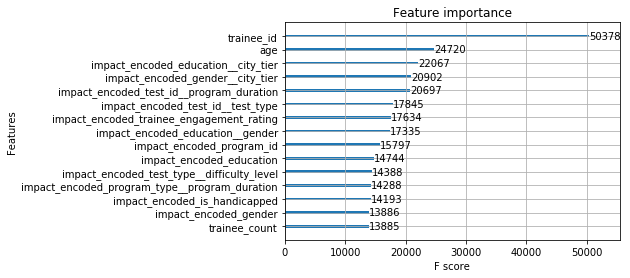

In [123]:
xgb.plot_importance(model,max_num_features=15);

In [125]:
df_raw.to_csv(f'{PATH}\\AV_Stud\\xgb_train_cleaned.csv', index=False)
df_test.to_csv(f'{PATH}\\AV_Stud\\xgb_test_cleaned.csv', index=False)

## xgb anokas

In [3]:
df_raw = pd.read_csv(f'{PATH}\\AV_Stud\\xgb_train_cleaned.csv')
df_test = pd.read_csv(f'{PATH}\\AV_Stud\\xgb_test_cleaned.csv')

In [5]:
df_raw.drop('trainee_id', axis =1, inplace=True)
df_test.drop('trainee_id', axis =1, inplace=True)

df_raw.drop('test_id', axis =1, inplace=True)
df_test.drop('test_id', axis =1, inplace=True)

In [9]:
df_raw['is_age_20_30'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('age>=20. & age<=30.').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_age_30_40'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('age>=30. & age<=40.').index
df_raw.iloc[my_query, -1] = 1

df_test['is_age_20_30'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age>=20. & age<=30.').index
df_test.iloc[my_query, -1] = 1

df_test['is_age_30_40'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age>=30. & age<=40.').index
df_test.iloc[my_query, -1] = 1

In [25]:
import mlcrate

In [26]:
params = {}
params['booster'] = 'gbtree'
#params['updater'] = 'coord_descent'
params["objective"] = "binary:logistic"
params['eval_metric'] = 'auc'
params["eta"] = 0.05 #0.03
params["subsample"] = .85
params["silent"] = 0
params['verbose'] = 2
params["max_depth"] = 11
params["seed"] = 1
params["max_delta_step"] = 4
params['scale_pos_weight'] =  0.4380049934141978
params["gamma"] = 0.6 #.5 #.1 #.2
params['colsample_bytree'] = 0.9
params['nrounds'] = 2500 #3600 #2000 #4000

In [31]:
model, p_train, p_test = mlcrate.xgb.train_kfold(params, df_raw, target, df_test, folds =7, stratify=target)

[mlcrate] Training 7 stratified XGBoost models on training set (73147, 61) with test set (31349, 61)
[mlcrate] Running fold 0, 62697 train samples, 10450 validation samples
[0]	train-auc:0.792055	valid-auc:0.704242
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.810779	valid-auc:0.720031
[2]	train-auc:0.819467	valid-auc:0.725405
[3]	train-auc:0.825992	valid-auc:0.727248
[4]	train-auc:0.829709	valid-auc:0.729409
[5]	train-auc:0.832152	valid-auc:0.731301
[6]	train-auc:0.834853	valid-auc:0.733199
[7]	train-auc:0.838118	valid-auc:0.733364
[8]	train-auc:0.840375	valid-auc:0.734197
[9]	train-auc:0.841851	valid-auc:0.734797
[10]	train-auc:0.843851	valid-auc:0.734994
[11]	train-auc:0.845404	valid-auc:0.735378
[12]	train-auc:0.847211	valid-auc:0.735713
[13]	train-auc:0.849296	valid-auc:0.735609
[14]	train-auc:0.850991	valid-auc:0.735679
[15]	train-auc:0.851657	valid-auc:0.736219
[16]	t

[183]	train-auc:0.959211	valid-auc:0.746818
[184]	train-auc:0.959555	valid-auc:0.746978
[185]	train-auc:0.959743	valid-auc:0.746925
[186]	train-auc:0.959778	valid-auc:0.746921
[187]	train-auc:0.960115	valid-auc:0.746999
[188]	train-auc:0.960358	valid-auc:0.746998
[189]	train-auc:0.96093	valid-auc:0.746916
[190]	train-auc:0.961234	valid-auc:0.746883
[191]	train-auc:0.961691	valid-auc:0.746864
[192]	train-auc:0.962029	valid-auc:0.746951
[193]	train-auc:0.962489	valid-auc:0.746999
[194]	train-auc:0.962866	valid-auc:0.747096
[195]	train-auc:0.963356	valid-auc:0.74696
[196]	train-auc:0.963592	valid-auc:0.747012
[197]	train-auc:0.963809	valid-auc:0.747054
[198]	train-auc:0.964222	valid-auc:0.747067
[199]	train-auc:0.964446	valid-auc:0.747099
[200]	train-auc:0.964615	valid-auc:0.747115
[201]	train-auc:0.964878	valid-auc:0.74712
[202]	train-auc:0.965368	valid-auc:0.747166
[203]	train-auc:0.965726	valid-auc:0.747164
[204]	train-auc:0.966	valid-auc:0.747195
[205]	train-auc:0.966445	valid-auc:0.7

C:\ProgramData\Anaconda3\lib\site-packages\mlcrate\backend.py:7: UserWarning: Timer.format_elapsed() has been deprecated in favour of Timer.fsince() and will be removed soon
  warn(message)


[mlcrate] Finished training fold 0 - took 48s - running score 0.747333
[mlcrate] Running fold 1, 62697 train samples, 10450 validation samples
[0]	train-auc:0.790873	valid-auc:0.717558
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.808673	valid-auc:0.733986
[2]	train-auc:0.816236	valid-auc:0.738913
[3]	train-auc:0.821711	valid-auc:0.743052
[4]	train-auc:0.825566	valid-auc:0.745982
[5]	train-auc:0.828671	valid-auc:0.747562
[6]	train-auc:0.831671	valid-auc:0.747397
[7]	train-auc:0.834306	valid-auc:0.748607
[8]	train-auc:0.835955	valid-auc:0.749295
[9]	train-auc:0.838177	valid-auc:0.74959
[10]	train-auc:0.839973	valid-auc:0.750193
[11]	train-auc:0.842007	valid-auc:0.750757
[12]	train-auc:0.843963	valid-auc:0.751312
[13]	train-auc:0.845546	valid-auc:0.751623
[14]	train-auc:0.847264	valid-auc:0.752136
[15]	train-auc:0.848376	valid-auc:0.752138
[16]	train-auc:0.850043	valid-auc:0.7

[183]	train-auc:0.963745	valid-auc:0.760105
[184]	train-auc:0.964099	valid-auc:0.760133
[185]	train-auc:0.964388	valid-auc:0.760201
[186]	train-auc:0.964625	valid-auc:0.760177
[187]	train-auc:0.96512	valid-auc:0.760363
[188]	train-auc:0.965428	valid-auc:0.76033
[189]	train-auc:0.965606	valid-auc:0.760312
[190]	train-auc:0.96583	valid-auc:0.760497
[191]	train-auc:0.966499	valid-auc:0.760577
[192]	train-auc:0.966683	valid-auc:0.76065
[193]	train-auc:0.967023	valid-auc:0.760583
[194]	train-auc:0.967481	valid-auc:0.760565
[195]	train-auc:0.967663	valid-auc:0.760563
[196]	train-auc:0.967893	valid-auc:0.760613
[197]	train-auc:0.968463	valid-auc:0.760903
[198]	train-auc:0.968576	valid-auc:0.760913
[199]	train-auc:0.968673	valid-auc:0.76091
[200]	train-auc:0.969049	valid-auc:0.761015
[201]	train-auc:0.969161	valid-auc:0.761092
[202]	train-auc:0.969401	valid-auc:0.761064
[203]	train-auc:0.969705	valid-auc:0.761055
[204]	train-auc:0.970157	valid-auc:0.760909
[205]	train-auc:0.970375	valid-auc:0.

[78]	train-auc:0.911013	valid-auc:0.740442
[79]	train-auc:0.911684	valid-auc:0.740567
[80]	train-auc:0.91223	valid-auc:0.740747
[81]	train-auc:0.912878	valid-auc:0.740865
[82]	train-auc:0.913149	valid-auc:0.740871
[83]	train-auc:0.913572	valid-auc:0.740918
[84]	train-auc:0.91412	valid-auc:0.741137
[85]	train-auc:0.914956	valid-auc:0.741044
[86]	train-auc:0.915429	valid-auc:0.741019
[87]	train-auc:0.916418	valid-auc:0.741219
[88]	train-auc:0.916993	valid-auc:0.741459
[89]	train-auc:0.917605	valid-auc:0.741584
[90]	train-auc:0.918772	valid-auc:0.741611
[91]	train-auc:0.918906	valid-auc:0.741611
[92]	train-auc:0.919754	valid-auc:0.741714
[93]	train-auc:0.920327	valid-auc:0.741702
[94]	train-auc:0.921133	valid-auc:0.741556
[95]	train-auc:0.9215	valid-auc:0.741726
[96]	train-auc:0.922219	valid-auc:0.741899
[97]	train-auc:0.922814	valid-auc:0.742046
[98]	train-auc:0.92347	valid-auc:0.741976
[99]	train-auc:0.924784	valid-auc:0.742239
[100]	train-auc:0.925212	valid-auc:0.74229
[101]	train-auc:

[52]	train-auc:0.890839	valid-auc:0.745364
[53]	train-auc:0.891523	valid-auc:0.745329
[54]	train-auc:0.892527	valid-auc:0.745584
[55]	train-auc:0.893009	valid-auc:0.745707
[56]	train-auc:0.894365	valid-auc:0.74591
[57]	train-auc:0.895327	valid-auc:0.745992
[58]	train-auc:0.896003	valid-auc:0.746006
[59]	train-auc:0.896969	valid-auc:0.746215
[60]	train-auc:0.898093	valid-auc:0.746089
[61]	train-auc:0.898545	valid-auc:0.746107
[62]	train-auc:0.899096	valid-auc:0.746212
[63]	train-auc:0.899553	valid-auc:0.746176
[64]	train-auc:0.899946	valid-auc:0.746026
[65]	train-auc:0.900263	valid-auc:0.745986
[66]	train-auc:0.900893	valid-auc:0.746162
[67]	train-auc:0.901531	valid-auc:0.746156
[68]	train-auc:0.902118	valid-auc:0.746223
[69]	train-auc:0.903118	valid-auc:0.746248
[70]	train-auc:0.903625	valid-auc:0.746398
[71]	train-auc:0.904195	valid-auc:0.746503
[72]	train-auc:0.905089	valid-auc:0.746791
[73]	train-auc:0.90559	valid-auc:0.746783
[74]	train-auc:0.906117	valid-auc:0.746937
[75]	train-au

[241]	train-auc:0.976132	valid-auc:0.75128
[242]	train-auc:0.976292	valid-auc:0.751303
[243]	train-auc:0.976447	valid-auc:0.751323
[244]	train-auc:0.976718	valid-auc:0.751234
[245]	train-auc:0.976926	valid-auc:0.751153
[246]	train-auc:0.977053	valid-auc:0.751058
[247]	train-auc:0.977335	valid-auc:0.75097
[248]	train-auc:0.977603	valid-auc:0.751045
[249]	train-auc:0.977886	valid-auc:0.751071
[250]	train-auc:0.978187	valid-auc:0.751095
[251]	train-auc:0.978511	valid-auc:0.751233
[252]	train-auc:0.978706	valid-auc:0.751271
[253]	train-auc:0.978858	valid-auc:0.751257
[254]	train-auc:0.979075	valid-auc:0.751308
[255]	train-auc:0.979129	valid-auc:0.751321
[256]	train-auc:0.979616	valid-auc:0.751438
[257]	train-auc:0.979891	valid-auc:0.751525
[258]	train-auc:0.979963	valid-auc:0.751544
[259]	train-auc:0.980242	valid-auc:0.751658
[260]	train-auc:0.980409	valid-auc:0.751782
[261]	train-auc:0.980506	valid-auc:0.751799
[262]	train-auc:0.980789	valid-auc:0.751723
[263]	train-auc:0.980988	valid-auc

[159]	train-auc:0.951421	valid-auc:0.759819
[160]	train-auc:0.951981	valid-auc:0.759924
[161]	train-auc:0.952808	valid-auc:0.759903
[162]	train-auc:0.953078	valid-auc:0.759899
[163]	train-auc:0.953337	valid-auc:0.759917
[164]	train-auc:0.953653	valid-auc:0.759873
[165]	train-auc:0.954233	valid-auc:0.75999
[166]	train-auc:0.954746	valid-auc:0.760071
[167]	train-auc:0.9552	valid-auc:0.759964
[168]	train-auc:0.955472	valid-auc:0.759903
[169]	train-auc:0.95567	valid-auc:0.759916
[170]	train-auc:0.956073	valid-auc:0.759902
[171]	train-auc:0.956238	valid-auc:0.759835
[172]	train-auc:0.956356	valid-auc:0.759912
[173]	train-auc:0.95686	valid-auc:0.759941
[174]	train-auc:0.957389	valid-auc:0.760156
[175]	train-auc:0.957879	valid-auc:0.760269
[176]	train-auc:0.958115	valid-auc:0.760262
[177]	train-auc:0.958616	valid-auc:0.760241
[178]	train-auc:0.959157	valid-auc:0.760254
[179]	train-auc:0.959677	valid-auc:0.760276
[180]	train-auc:0.960037	valid-auc:0.760178
[181]	train-auc:0.960522	valid-auc:0.

[52]	train-auc:0.891792	valid-auc:0.741679
[53]	train-auc:0.892672	valid-auc:0.741762
[54]	train-auc:0.893557	valid-auc:0.741735
[55]	train-auc:0.895055	valid-auc:0.742192
[56]	train-auc:0.895791	valid-auc:0.742357
[57]	train-auc:0.896614	valid-auc:0.742432
[58]	train-auc:0.897293	valid-auc:0.742386
[59]	train-auc:0.897773	valid-auc:0.742368
[60]	train-auc:0.898489	valid-auc:0.74227
[61]	train-auc:0.899012	valid-auc:0.742159
[62]	train-auc:0.899513	valid-auc:0.742115
[63]	train-auc:0.900264	valid-auc:0.742095
[64]	train-auc:0.900959	valid-auc:0.742282
[65]	train-auc:0.90148	valid-auc:0.742396
[66]	train-auc:0.902121	valid-auc:0.742411
[67]	train-auc:0.902612	valid-auc:0.742679
[68]	train-auc:0.903729	valid-auc:0.742849
[69]	train-auc:0.904555	valid-auc:0.742875
[70]	train-auc:0.904973	valid-auc:0.742955
[71]	train-auc:0.905649	valid-auc:0.743008
[72]	train-auc:0.906314	valid-auc:0.743112
[73]	train-auc:0.907166	valid-auc:0.74322
[74]	train-auc:0.907415	valid-auc:0.743309
[75]	train-auc

[241]	train-auc:0.975144	valid-auc:0.74872
[242]	train-auc:0.975535	valid-auc:0.748756
[243]	train-auc:0.975754	valid-auc:0.748781
[244]	train-auc:0.976073	valid-auc:0.748827
[245]	train-auc:0.976304	valid-auc:0.748767
[246]	train-auc:0.976427	valid-auc:0.748779
[247]	train-auc:0.976668	valid-auc:0.748799
[248]	train-auc:0.977105	valid-auc:0.748891
[249]	train-auc:0.977158	valid-auc:0.748944
[250]	train-auc:0.977235	valid-auc:0.748895
[251]	train-auc:0.977506	valid-auc:0.748752
[252]	train-auc:0.977628	valid-auc:0.748781
[253]	train-auc:0.977862	valid-auc:0.748906
[254]	train-auc:0.977924	valid-auc:0.748948
[255]	train-auc:0.978123	valid-auc:0.748925
[256]	train-auc:0.978234	valid-auc:0.74895
[257]	train-auc:0.978553	valid-auc:0.749018
[258]	train-auc:0.978838	valid-auc:0.748965
[259]	train-auc:0.979064	valid-auc:0.748929
[260]	train-auc:0.979227	valid-auc:0.74895
[261]	train-auc:0.97949	valid-auc:0.748919
[262]	train-auc:0.979668	valid-auc:0.748973
[263]	train-auc:0.979994	valid-auc:0

[37]	train-auc:0.87653	valid-auc:0.751703
[38]	train-auc:0.877488	valid-auc:0.75178
[39]	train-auc:0.878401	valid-auc:0.751719
[40]	train-auc:0.879333	valid-auc:0.751835
[41]	train-auc:0.880365	valid-auc:0.75207
[42]	train-auc:0.881817	valid-auc:0.752086
[43]	train-auc:0.882724	valid-auc:0.752197
[44]	train-auc:0.883815	valid-auc:0.752251
[45]	train-auc:0.884681	valid-auc:0.75233
[46]	train-auc:0.885533	valid-auc:0.752576
[47]	train-auc:0.886667	valid-auc:0.752468
[48]	train-auc:0.887795	valid-auc:0.752549
[49]	train-auc:0.888727	valid-auc:0.752612
[50]	train-auc:0.889305	valid-auc:0.752636
[51]	train-auc:0.890077	valid-auc:0.752687
[52]	train-auc:0.891342	valid-auc:0.752724
[53]	train-auc:0.892145	valid-auc:0.752755
[54]	train-auc:0.892795	valid-auc:0.752814
[55]	train-auc:0.893261	valid-auc:0.75286
[56]	train-auc:0.893845	valid-auc:0.752945
[57]	train-auc:0.894818	valid-auc:0.752716
[58]	train-auc:0.895236	valid-auc:0.752651
[59]	train-auc:0.895953	valid-auc:0.752646
[60]	train-auc:0

[226]	train-auc:0.972523	valid-auc:0.757579
[227]	train-auc:0.972839	valid-auc:0.757655
[228]	train-auc:0.973268	valid-auc:0.757741
[229]	train-auc:0.973532	valid-auc:0.757789
[230]	train-auc:0.973886	valid-auc:0.757685
[231]	train-auc:0.974172	valid-auc:0.757673
[232]	train-auc:0.974309	valid-auc:0.757565
[233]	train-auc:0.97448	valid-auc:0.757545
[234]	train-auc:0.974685	valid-auc:0.757505
[235]	train-auc:0.974891	valid-auc:0.757379
[236]	train-auc:0.975031	valid-auc:0.757305
[237]	train-auc:0.975171	valid-auc:0.75724
[238]	train-auc:0.975394	valid-auc:0.757141
[239]	train-auc:0.975648	valid-auc:0.757158
[240]	train-auc:0.975901	valid-auc:0.756953
[241]	train-auc:0.976391	valid-auc:0.757017
Stopping. Best iteration:
[191]	train-auc:0.963478	valid-auc:0.757979

[mlcrate] Finished training fold 6 - took 54s - running score 0.753265
[mlcrate] Finished training 7 XGBoost models, took 7m24s


In [33]:
p_train

array([ 0.21688,  0.40872,  0.87946, ...,  0.80383,  0.69749,  0.93272], dtype=float32)